In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from patsy import dmatrices
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split, cross_val_score
from sklearn import metrics, neighbors, grid_search, cross_validation
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.grid_search import GridSearchCV
import psycopg2
import seaborn as sns

%matplotlib inline

## Pre-Task: Describe the goals of your study

The goals of my study are to analyze and clean the data to clearly show the affect sex, gender, and class have on a persons chances of survival. I will use logistic regression, KNN, and grid search to show my results. 

## Part 1: Aquire the Data

In [2]:
#psql -h dsi.c20gkj5cvu3l.us-east-1.rds.amazonaws.com -p 5432 -U dsi_student titanic
#password: gastudents

#### 1. Connect to the remote database

In [3]:
conn = psycopg2.connect("host=dsi.c20gkj5cvu3l.us-east-1.rds.amazonaws.com port=5432 user=dsi_student password=gastudents dbname=titanic")

In [4]:
train = pd.read_sql('SELECT * FROM train', con = conn)

#### 2. Query the database and aggregate the data

In [5]:
train.head()

,index,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,None,S
1,1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,None,S
3,3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,None,S


#### 5. What are the risks and assumptions of our data? 

The assumptions of our data are that the null values for age will be filled with the average value of age and that the train and test set will be proper samples of the full dataset. 

## Part 2: Exploratory Data Analysis

#### 1. Describe the Data

In [6]:
df2= train.drop(["PassengerId", "index", "Name", "SibSp", "Parch", "Ticket", "Fare", "Cabin", "Embarked"], axis=1)

Age Description
count    714.000000
mean      29.699118
std       14.526497
min        0.420000
25%       20.125000
50%       28.000000
75%       38.000000
max       80.000000
Name: Age, dtype: float64
Age Histogram
Axes(0.125,0.125;0.775x0.775)


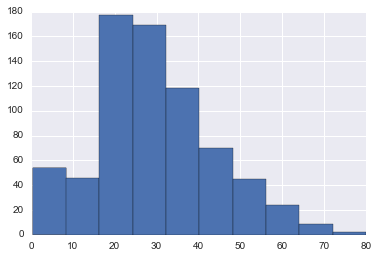

In [7]:
print "Age Description"
print df2['Age'].describe()
print "Age Histogram"
print df2['Age'].hist()

In [8]:
df2['Age']= train["Age"].fillna(value=(train['Age'].mean()))

In [9]:
df2.dtypes

Survived      int64
Pclass        int64
Sex          object
Age         float64
dtype: object

In [10]:
df2['Sex'].value_counts()

male      577
female    314
Name: Sex, dtype: int64

In [11]:
df2['Pclass'].value_counts()

3    491
1    216
2    184
Name: Pclass, dtype: int64

In [12]:
print '"Survived" column values where 1 = Survived and 0 = Dead'
print df2['Survived'].value_counts()

"Survived" column values where 1 = Survived and 0 = Dead
0    549
1    342
Name: Survived, dtype: int64


#### 2. Visualize the Data

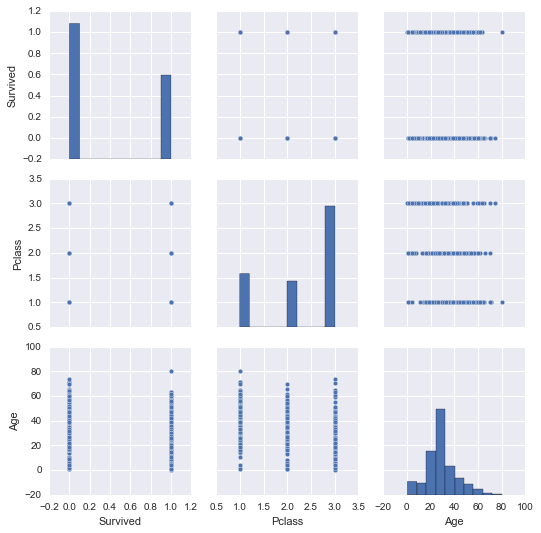

In [13]:
sns.pairplot(df2)

## Part 3: Data Wrangling

#### 1. Create Dummy Variables for *Sex* 

In [14]:
def sex_binary(x):
    if x == 'male':
        return 1
    if x == 'female':
        return 0
    
df2['Sex']=df2['Sex'].apply(sex_binary)

## Part 4: Logistic Regression and Model Validation

#### 1. Define the variables that we will use in our classification analysis

In [15]:
y = df2['Survived']
X= df2[['Age', 'Pclass', 'Sex']]

#### 2. Transform "Y" into a 1-Dimensional Array for SciKit-Learn

In [16]:
y = np.ravel(y)

#### 3. Conduct the logistic regression

In [17]:
model = LogisticRegression()
model.fit(X, y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [18]:
model.score(X, y)

0.79685746352413023

#### 4. Examine the coefficients to see our correlations

In [19]:
model.coef_

array([[-0.02413822, -0.97924449, -2.4057234 ]])

In [20]:
coeffs = pd.DataFrame(model.coef_, columns = ['Pclass', 'Sex', 'Age'], index =['Survived'])
coeffs

,Pclass,Sex,Age
Survived,-0.024138,-0.979244,-2.405723


#### 6. Test the Model by introducing a *Test* or *Validaton* set 

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
model2 = LogisticRegression()
model2.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

#### 7. Predict the class labels for the *Test* set

In [22]:
predicted = model2.predict(X_test)

#### 8. Predict the class probabilities for the *Test* set

In [23]:
prob = model2.predict_proba(X_test)

#### 9. Evaluate the *Test* set

In [24]:
print(metrics.accuracy_score(y_test, predicted))
print(metrics.roc_auc_score(y_test, prob[:, 1]))

0.803389830508
0.87669047619


#### 10. Cross validate the test set

In [25]:
scores = cross_val_score(LogisticRegression(), X, y, scoring='accuracy', cv=10)
print(scores)
print(scores.mean())

[ 0.8         0.81111111  0.7752809   0.87640449  0.80898876  0.76404494
  0.7752809   0.76404494  0.82022472  0.77272727]
0.796810804676


#### 11. Check the Classification Report

In [26]:
print classification_report(y_test, predicted)

             precision    recall  f1-score   support

          0       0.81      0.87      0.84       175
          1       0.79      0.71      0.75       120

avg / total       0.80      0.80      0.80       295



#### 12. What do the classification metrics tell us?

Classification metrics predict class labels given input data. There are two possible output classes multi-class classification, and binary classification. A few significant classification metrics are Accuracy, Confusion Matrices, Log-loss, AUC, and Precision-Recall. 

#### 13. Check the Confusion Matrix

In [27]:
conmat = (metrics.confusion_matrix(y_test, predicted))
confusion = pd.DataFrame(conmat, index=['Dead', 'Survived'], columns=['Predicted_Dead', 'Predicted_Survived'])
confusion

,Predicted_Dead,Predicted_Survived
Dead,152,23
Survived,35,85


Accuracy: 0.8034
Confusion Matrix for Type I and Type II Error


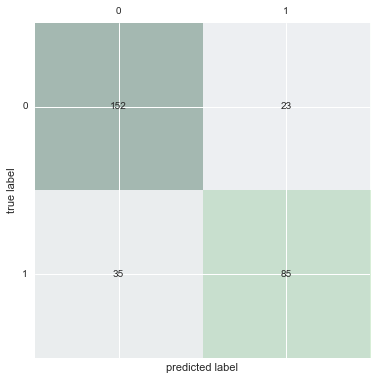

In [29]:
print('Accuracy: %.4f' % accuracy_score(y_test, predicted))

fig, ax = plt.subplots(figsize=(6, 6))
ax.matshow(conmat, cmap=plt.cm.Greens, alpha=0.3)
for i in range(conmat.shape[0]):
    for j in range(conmat.shape[1]):
        ax.text(x=j, y=i,
            s=conmat[i, j],
            va='center', ha='center')
plt.xlabel('predicted label')
plt.ylabel('true label')
print('Confusion Matrix for Type I and Type II Error')
plt.show()

#### 14. What does the Confusion Matrix tell us? 

Confusion matrices describe the performance of classification models on a set of data where we know the true values. 

#### 15. Plot the ROC curve

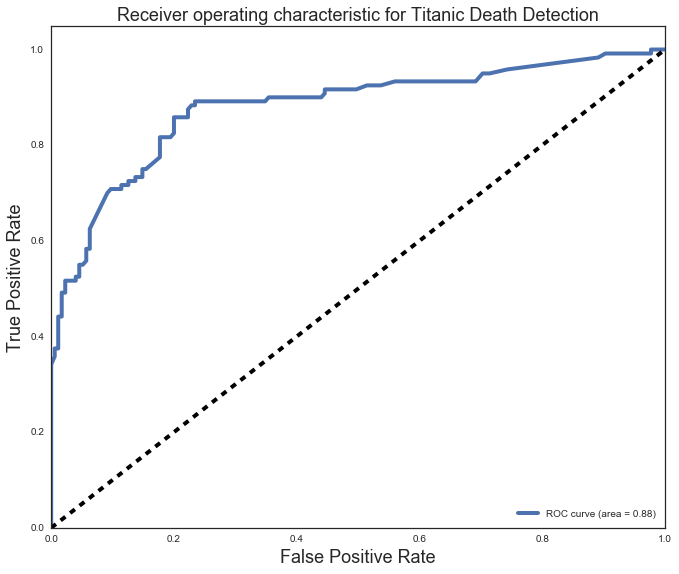

In [30]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
%matplotlib inline


Y_score = model.decision_function(X_test)

FPR = dict()
TPR = dict()
ROC_AUC = dict()

# For class 1, find the area under the curve
FPR[1], TPR[1], _ = roc_curve(y_test, Y_score)
ROC_AUC[1] = auc(FPR[1], TPR[1])

# Plot of a ROC curve for class 1 (has_cancer)
plt.figure(figsize=[11,9])
plt.plot(FPR[1], TPR[1], label='ROC curve (area = %0.2f)' % ROC_AUC[1], linewidth=4)
plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('Receiver operating characteristic for Titanic Death Detection', fontsize=18)
plt.legend(loc="lower right")
plt.show()

#### 16. What does the ROC curve tell us?

The ROC curve plots the true positive rate(a.k.a sensitivity) against the false positive rate(a.k.a. fall-out) to illustrate the preformance of  binary classifier system.

## Part 5: Gridsearch

#### 1. Use GridSearchCV with logistic regression to search for optimal parameters 

- Use the provided parameter grid. Feel free to add if you like (such as n_jobs).
- Use 5-fold cross-validation.

### Given:
```logreg_parameters = {
    'penalty':['l1','l2'],
    'C':np.logspace(-5,1,50),
    'solver':['liblinear']
}```

In [32]:
kf = cross_validation.KFold(len(df2), n_folds = 5)
gs =GridSearchCV(LogisticRegression(class_weight='balanced'),
                   {'penalty':['l1','l2'],"C":np.logspace(-5,1,50),'solver':['liblinear']},
                   n_jobs=1
                  )

print 'GridSearch:'
print gs

GridSearch:
GridSearchCV(cv=None, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'penalty': ['l1', 'l2'], 'C': array([  1.00000e-05,   1.32571e-05,   1.75751e-05,   2.32995e-05,
         3.08884e-05,   4.09492e-05,   5.42868e-05,   7.19686e-05,
         9.54095e-05,   1.26486e-04,   1.67683e-04,   2.22300e-04,
         2.94705e-04,   3.90694e-04,   5.17947e-04,   6.8...6e+00,   4.29193e+00,   5.68987e+00,
         7.54312e+00,   1.00000e+01]), 'solver': ['liblinear']},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)


In [33]:
gs.fit(X_train, y_train)


GridSearchCV(cv=None, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'penalty': ['l1', 'l2'], 'C': array([  1.00000e-05,   1.32571e-05,   1.75751e-05,   2.32995e-05,
         3.08884e-05,   4.09492e-05,   5.42868e-05,   7.19686e-05,
         9.54095e-05,   1.26486e-04,   1.67683e-04,   2.22300e-04,
         2.94705e-04,   3.90694e-04,   5.17947e-04,   6.8...6e+00,   4.29193e+00,   5.68987e+00,
         7.54312e+00,   1.00000e+01]), 'solver': ['liblinear']},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

#### 2. Print out the best parameters and best score. Are they better than the vanilla logistic regression?

In [34]:
print('Grid Search Best Score: %.4f' % gs.best_score_)
print('Grid Search Best Parameter for C: ')
print gs.best_params_

Grid Search Best Score: 0.7819
Grid Search Best Parameter for C: 
{'penalty': 'l1', 'C': 0.10985411419875572, 'solver': 'liblinear'}


#### 3. Explain the difference between the difference between the L1 (Lasso) and L2 (Ridge) penalties on the model coefficients.

L2(Ridge) penalty normally results in all small but non-zero regression coefficients while L1(Lasso) results in many coefficients shrinking to zero and a few with little shrinkage. 

#### 4. What hypothetical situations are the Ridge and Lasso penalties useful?

The Ridge and Lasso penalties shrink the estimates of the regression coefficients to prevent overfitting. Situations where these penalties would be useful are when you want a very small false positive rate. For example in the case of spam emails, the filter for emails should be as accurate as possible because missorted emails could result in missed opportunities. 

#### 5. [BONUS] Explain how the regularization strength (C) modifies the regression loss function. Why do the Ridge and Lasso penalties have their respective effects on the coefficients?

#### 6.a. [BONUS] You decide that you want to minimize false positives. Use the predicted probabilities from the model to set your threshold for labeling the positive class to need at least 90% confidence. How and why does this affect your confusion matrix?

## Part 6: Gridsearch and kNN

#### 1. Perform Gridsearch for the same classification problem as above, but use KNeighborsClassifier as your estimator

At least have number of neighbors and weights in your parameters dictionary.

In [37]:
knn1 = neighbors.KNeighborsClassifier(n_neighbors=5, weights='uniform')
print 'KNN with Uniform Weight:'
print knn1.fit(X, y)
print 'KNN Score:'
print knn1.score(X, y)

knn_gs = grid_search.GridSearchCV(
    estimator=(knn1),
    param_grid={'penalty':['l1','l2'], 'C':np.logspace(-5,1,50), 'solver':['liblinear']}, scoring ='accuracy',
    cv=kf, n_jobs=-1
)
print 'KNN Uniform Weight GridSearch:'
print knn_gs

KNN with Uniform Weight:
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')
KNN Score:
0.817059483726
KNN Uniform Weight GridSearch:
GridSearchCV(cv=sklearn.cross_validation.KFold(n=891, n_folds=5, shuffle=False, random_state=None),
       error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'penalty': ['l1', 'l2'], 'C': array([  1.00000e-05,   1.32571e-05,   1.75751e-05,   2.32995e-05,
         3.08884e-05,   4.09492e-05,   5.42868e-05,   7.19686e-05,
         9.54095e-05,   1.26486e-04,   1.67683e-04,   2.22300e-04,
         2.94705e-04,   3.90694e-04,   5.17947e-04,   6.8...6e+00,   4.29193e+00,   5.68987e+00,
         7.54312e+00,   1.00000e+01]), 'solver': ['lib

In [39]:
knn2 = neighbors.KNeighborsClassifier(n_neighbors=5, weights='distance')
print 'KNN with Distance Weight:'
print knn2.fit(X, y)
print 'KNN Score:'
print knn2.score(X, y)

knn2_gs = grid_search.GridSearchCV(
    estimator=(knn2),
    param_grid={'penalty':['l1','l2'], 'C':np.logspace(-5,1,50), 'solver':['liblinear']}, scoring ='accuracy',
    cv=kf, n_jobs=-1
)

print 'KNN Distance Weighted GridSearch:'
print knn2_gs

KNN with Distance Weight:
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='distance')
KNN Score:
0.868686868687
KNN Distance Weighted GridSearch:
GridSearchCV(cv=sklearn.cross_validation.KFold(n=891, n_folds=5, shuffle=False, random_state=None),
       error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='distance'),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'penalty': ['l1', 'l2'], 'C': array([  1.00000e-05,   1.32571e-05,   1.75751e-05,   2.32995e-05,
         3.08884e-05,   4.09492e-05,   5.42868e-05,   7.19686e-05,
         9.54095e-05,   1.26486e-04,   1.67683e-04,   2.22300e-04,
         2.94705e-04,   3.90694e-04,   5.17947e-04,   6.8...6e+00,   4.29193e+00,   5.68987e+00,
         7.54312e+00,   1.00000e+01]), 'solver':

#### 2. Print the best parameters and score for the gridsearched kNN model. How does it compare to the logistic regression model?

In [41]:
print('Grid Search Best Score: %.4f' % knn_gs.best_score_)
print('Grid Search Best Parameter for C: ')
print knn_gs.best_params_

AttributeError: 'GridSearchCV' object has no attribute 'best_score_'

#### 3. How does the number of neighbors affect the bias-variance tradeoff of your model?

#### [BONUS] Why?

The number of neighbors considered affects the bias-variance tradeoff because the larger the distance, the more variance there is and the error margin will increase as the variance increases.

#### 4. In what hypothetical scenario(s) might you prefer logistic regression over kNN, aside from model performance metrics?

#### 5. Fit a new kNN model with the optimal parameters found in gridsearch. 

#### 6. Construct the confusion matrix for the optimal kNN model. Is it different from the logistic regression model? If so, how?

#### 7. [BONUS] Plot the ROC curves for the optimized logistic regression model and the optimized kNN model on the same plot.

## Part 7: [BONUS] Precision-recall

#### 1. Gridsearch the same parameters for logistic regression but change the scoring function to 'average_precision'

`'average_precision'` will optimize parameters for area under the precision-recall curve instead of for accuracy.

#### 2. Examine the best parameters and score. Are they different than the logistic regression gridsearch in part 5?

#### 3. Create the confusion matrix. Is it different than when you optimized for the accuracy? If so, why would this be?

#### 4. Plot the precision-recall curve. What does this tell us as opposed to the ROC curve?

[See the sklearn plotting example here.](http://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html)

## Part 8: [VERY BONUS] Decision trees, ensembles, bagging

#### 1. Gridsearch a decision tree classifier model on the data, searching for optimal depth. Create a new decision tree model with the optimal parameters.

#### 2. Compare the performace of the decision tree model to the logistic regression and kNN models.

#### 3. Plot all three optimized models' ROC curves on the same plot. 

#### 4. Use sklearn's BaggingClassifier with the base estimator your optimized decision tree model. How does the performance compare to the single decision tree classifier?

#### 5. Gridsearch the optimal n_estimators, max_samples, and max_features for the bagging classifier.

#### 6. Create a bagging classifier model with the optimal parameters and compare it's performance to the other two models.